# Rider @ Virginia PBP States and Markov Transition Probabilities

This notebook:

1. Takes the text play-by-play (PBP) for the Rider @ Virginia game.
2. Parses it into a structured PBP table (`time`, `play`, `rid`, `uva`).
3. Computes score differential from Virginia's perspective and maps it into **score-differential states**.
4. Loads a global Markov transition model (`transition_probs.csv`) and, for each row of the game,
   attaches the **transition probabilities** for where the score differential is likely to end after one Markov step (e.g., a 10-possession window).


In [10]:
import pandas as pd
import numpy as np

## Raw play-by-play text

The block below is the first-half play-by-play for Rider @ Virginia, copied from ESPN.  
Each line has the format:

`TIME  PLAY DESCRIPTION ...  RID  UVA`

We will parse these into structured columns.


In [11]:
# Raw text for first-half PBP
raw_text = """20:00 Start game 0 0
19:59 Jump Ball won by Rider 0 0
19:59 Jump Ball lost by Virginia 0 0
19:43 Flash Burton missed Jumper. 0 0
19:40 Malik Thomas Defensive Rebound. 0 0
19:25 Thijs De Ridder missed Three Point Jumper. 0 0
19:22 Rider Defensive Rebound. 0 0
18:58 Zion Cruz missed Jumper. 0 0
18:54 Dallin Hall Defensive Rebound. 0 0
18:49 Malik Thomas missed Layup. 0 0
18:49 Mohamad Diallo Block. 0 0
18:44 Flash Burton Defensive Rebound. 0 0
18:39 Mohamad Diallo missed Layup. 0 0
18:37 Thijs De Ridder Defensive Rebound. 0 0
18:33 Foul on Zion Cruz. 0 0
18:18 Sam Lewis made Layup. Assisted by Malik Thomas. 0 2
17:58 Flash Burton Turnover. 0 2
17:58 Dallin Hall Steal. 0 2
17:55 Foul on Cole McCabe. 0 2
17:55 Sam Lewis missed Free Throw. 0 2
17:55 Virginia Deadball Team Rebound. 0 2
17:55 Mohamad Diallo subbing out for Rider 0 2
17:55 Shemani Fuller subbing in for Rider 0 2
17:54 Sam Lewis missed Free Throw. 0 2
17:53 Sam Lewis Offensive Rebound. 0 2
17:37 Johann Grunloh missed Dunk. 0 2
17:37 Cole McCabe Block. 0 2
17:37 Rider Defensive Rebound. 0 2
17:37 Davis Bynum subbing out for Rider 0 2
17:37 Antwan Wilson subbing in for Rider 0 2
17:12 Flash Burton made Jumper. 2 2
17:05 Foul on Shemani Fuller. 2 2
17:05 Thijs De Ridder missed Free Throw. 2 2
17:05 Virginia Deadball Team Rebound. 2 2
17:05 Thijs De Ridder missed Free Throw. 2 2
17:03 Thijs De Ridder Offensive Rebound. 2 2
17:01 Thijs De Ridder made Layup. 2 4
16:48 Flash Burton missed Layup. 2 4
16:45 Johann Grunloh Defensive Rebound. 2 4
16:40 Dallin Hall made Three Point Jumper. 2 7
16:11 Antwan Wilson made Layup. 4 7
16:04 Johann Grunloh made Dunk. Assisted by Dallin Hall. 4 9
15:38 Flash Burton missed Three Point Jumper. 4 9
15:35 Rider Offensive Rebound. 4 9
15:35 Official TV Timeout 4 9
15:35 Malik Thomas subbing out for Virginia 4 9
15:35 Johann Grunloh subbing out for Virginia 4 9
15:35 Dallin Hall subbing out for Virginia 4 9
15:35 Chance Mallory subbing in for Virginia 4 9
15:35 Jacari White subbing in for Virginia 4 9
15:35 Ugonna Onyenso subbing in for Virginia 4 9
15:35 Flash Burton subbing out for Rider 4 9
15:35 Kristupas Kepežinskas subbing in for Rider 4 9
15:33 Shemani Fuller missed Layup. 4 9
15:33 Ugonna Onyenso Block. 4 9
15:29 Sam Lewis Defensive Rebound. 4 9
15:08 Thijs De Ridder made Layup. 4 11
15:00 Foul on Chance Mallory. 4 11
14:40 Zion Cruz missed Jumper. 4 11
14:35 Shemani Fuller Offensive Rebound. 4 11
14:31 Foul on Jacari White. 4 11
14:31 Sam Lewis subbing out for Virginia 4 11
14:31 Elijah Gertrude subbing in for Virginia 4 11
14:20 Antwan Wilson missed Layup. 4 11
14:20 Ugonna Onyenso Block. 4 11
14:20 Rider Offensive Rebound. 4 11
14:13 Antwan Wilson missed Three Point Jumper. 4 11
14:10 Ugonna Onyenso Defensive Rebound. 4 11
14:02 Jacari White missed Three Point Jumper. 4 11
13:59 Chance Mallory Offensive Rebound. 4 11
13:52 Ugonna Onyenso missed Three Point Jumper. 4 11
13:51 Chance Mallory Offensive Rebound. 4 11
13:51 Foul on Kristupas Kepežinskas. 4 11
13:51 Antwan Wilson subbing out for Rider 4 11
13:51 Cole McCabe subbing out for Rider 4 11
13:51 Davis Bynum subbing in for Rider 4 11
13:51 Flash Burton subbing in for Rider 4 11
13:44 Foul on Davis Bynum. 4 11
13:44 Jacari White made Free Throw. 4 12
13:44 Jacari White made Free Throw. 4 13
13:44 Thijs De Ridder subbing out for Virginia 4 13
13:44 Martin Carrere subbing in for Virginia 4 13
13:44 Davis Bynum subbing out for Rider 4 13
13:44 Caleb Smith subbing in for Rider 4 13
13:44 Jacari White made Free Throw. 4 14
13:26 Foul on Elijah Gertrude. 4 14
13:22 Flash Burton made Jumper. Assisted by Shemani Fuller. 6 14
13:22 Foul on Elijah Gertrude. 6 14
13:22 Elijah Gertrude subbing out for Virginia 6 14
13:22 Malik Thomas subbing in for Virginia 6 14
13:22 Flash Burton made Free Throw. 7 14
13:04 Ugonna Onyenso made Jumper. 7 16
12:32 Flash Burton Turnover. 7 16
12:32 Malik Thomas Steal. 7 16
12:26 Jacari White missed Three Point Jumper. 7 16
12:24 Flash Burton Turnover. 7 16
12:24 Chance Mallory Steal. 7 16
12:23 Flash Burton Defensive Rebound. 7 16
12:22 Chance Mallory made Layup. 7 18
11:55 Flash Burton made Three Point Jumper. Assisted by Caleb Smith. 10 18
11:31 Malik Thomas missed Layup. 10 18
11:31 Ugonna Onyenso Offensive Rebound. 10 18
11:31 Foul on Zion Cruz. 10 18
11:31 Official TV Timeout 10 18
11:31 Chance Mallory subbing out for Virginia 10 18
11:31 Jacari White subbing out for Virginia 10 18
11:31 Thijs De Ridder subbing in for Virginia 10 18
11:31 Dallin Hall subbing in for Virginia 10 18
11:31 Zion Cruz subbing out for Rider 10 18
11:31 Shemani Fuller subbing out for Rider 10 18
11:31 Mohamad Diallo subbing in for Rider 10 18
11:31 Cole McCabe subbing in for Rider 10 18
11:27 Ugonna Onyenso missed Jumper. 10 18
11:22 Thijs De Ridder Offensive Rebound. 10 18
11:22 Thijs De Ridder made Two Point Tip Shot. 10 20
10:47 Flash Burton made Jumper. 12 20
10:40 Malik Thomas missed Three Point Jumper. 12 20
10:39 Thijs De Ridder Offensive Rebound. 12 20
10:36 Martin Carrere missed Three Point Jumper. 12 20
10:36 Mohamad Diallo Defensive Rebound. 12 20
10:36 Foul on Thijs De Ridder. 12 20
10:36 Ugonna Onyenso subbing out for Virginia 12 20
10:36 Johann Grunloh subbing in for Virginia 12 20
10:36 Caleb Smith subbing out for Rider 12 20
10:36 Zion Cruz subbing in for Rider 12 20
10:17 Zion Cruz made Layup. Assisted by Kristupas Kepežinskas. 14 20
10:07 Malik Thomas made Three Point Jumper. Assisted by Dallin Hall. 14 23
9:46 Zion Cruz missed Jumper. 14 23
9:42 Johann Grunloh Defensive Rebound. 14 23
9:36 Johann Grunloh missed Three Point Jumper. 14 23
9:32 Zion Cruz Defensive Rebound. 14 23
9:27 Foul on Thijs De Ridder. 14 23
9:27 Martin Carrere subbing out for Virginia 14 23
9:27 Sam Lewis subbing in for Virginia 14 23
9:27 Kristupas Kepežinskas subbing out for Rider 14 23
9:27 Antwan Wilson subbing in for Rider 14 23
9:21 Mohamad Diallo missed Layup. 14 23
9:21 Johann Grunloh Block. 14 23
9:17 Johann Grunloh Defensive Rebound. 14 23
9:15 Foul on Antwan Wilson. 14 23
9:15 Sam Lewis missed Free Throw. 14 23
9:15 Virginia Deadball Team Rebound. 14 23
9:15 Sam Lewis made Free Throw. 14 24
9:15 Thijs De Ridder subbing out for Virginia 14 24
9:15 Jacari White subbing in for Virginia 14 24
8:46 Zion Cruz missed Three Point Jumper. 14 24
8:43 Mohamad Diallo Offensive Rebound. 14 24
8:37 Foul on Malik Thomas. 14 24
8:37 Flash Burton missed Free Throw. 14 24
8:37 Rider Deadball Team Rebound. 14 24
8:37 Flash Burton made Free Throw. 15 24
8:37 Flash Burton made Free Throw. 16 24
8:26 Dallin Hall missed Three Point Jumper. 16 24
8:25 Virginia Offensive Rebound. 16 24
8:16 Jacari White missed Three Point Jumper. 16 24
8:12 Sam Lewis Offensive Rebound. 16 24
8:09 Foul on Antwan Wilson. 16 24
8:09 Malik Thomas made Free Throw. 16 25
8:09 Antwan Wilson subbing out for Rider 16 25
8:09 Jamir McNeil subbing in for Rider 16 25
8:09 Malik Thomas made Free Throw. 16 26
7:55 Foul on Malik Thomas. 16 26
7:55 Official TV Timeout 16 26
7:55 Cole McCabe made Free Throw. 17 26
7:55 Cole McCabe made Free Throw. 18 26
7:55 Dallin Hall subbing out for Virginia 18 26
7:55 Chance Mallory subbing in for Virginia 18 26
7:55 Jamir McNeil subbing out for Rider 18 26
7:55 Devean Williams subbing in for Rider 18 26
7:41 Chance Mallory missed Three Point Jumper. 18 26
7:38 Johann Grunloh Offensive Rebound. 18 26
7:35 Foul on Mohamad Diallo. 18 26
7:35 Malik Thomas made Free Throw. 18 27
7:35 Mohamad Diallo subbing out for Rider 18 27
7:35 Shemani Fuller subbing in for Rider 18 27
7:35 Malik Thomas made Free Throw. 18 28
7:18 Zion Cruz made Three Point Jumper. Assisted by Cole McCabe. 21 28
7:05 Sam Lewis missed Three Point Jumper. 21 28
7:02 Flash Burton Defensive Rebound. 21 28
6:53 Flash Burton Turnover. 21 28
6:53 Jacari White Steal. 21 28
6:51 Foul on Cole McCabe. 21 28
6:51 Jacari White missed Free Throw. 21 28
6:51 Virginia Deadball Team Rebound. 21 28
6:51 Malik Thomas subbing out for Virginia 21 28
6:51 Dallin Hall subbing in for Virginia 21 28
6:51 Jacari White missed Free Throw. 21 28
6:49 Sam Lewis Offensive Rebound. 21 28
6:45 Foul on Cole McCabe. 21 28
6:45 Johann Grunloh made Free Throw. 21 29
6:45 Shemani Fuller subbing out for Rider 21 29
6:45 Cole McCabe subbing out for Rider 21 29
6:45 Caleb Smith subbing in for Rider 21 29
6:45 Davis Bynum subbing in for Rider 21 29
6:45 Johann Grunloh made Free Throw. 21 30
6:23 Davis Bynum missed Jumper. 21 30
6:22 Caleb Smith Offensive Rebound. 21 30
6:22 Foul on Sam Lewis. 21 30
6:22 Caleb Smith made Free Throw. 22 30
6:22 Sam Lewis subbing out for Virginia 22 30
6:22 Thijs De Ridder subbing in for Virginia 22 30
6:22 Devean Williams subbing out for Rider 22 30
6:22 Kristupas Kepežinskas subbing in for Rider 22 30
6:22 Caleb Smith made Free Throw. 23 30
6:02 Thijs De Ridder made Jumper. 23 32
5:55 Foul on Chance Mallory. 23 32
5:55 Kristupas Kepežinskas made Free Throw. 24 32
5:55 Davis Bynum subbing out for Rider 24 32
5:55 Shemani Fuller subbing in for Rider 24 32
5:55 Kristupas Kepežinskas missed Free Throw. 24 32
5:54 Thijs De Ridder Defensive Rebound. 24 32
5:38 Jacari White missed Three Point Jumper. 24 32
5:34 Caleb Smith Defensive Rebound. 24 32
5:15 Foul on Dallin Hall. 24 32
5:15 Flash Burton missed Free Throw. 24 32
5:15 Rider Deadball Team Rebound. 24 32
5:15 Flash Burton made Free Throw. 25 32
4:59 Thijs De Ridder made Layup. 25 34
4:29 Kristupas Kepežinskas Turnover. 25 34
4:29 Kristupas Kepežinskas subbing out for Rider 25 34
4:29 Jamir McNeil subbing in for Rider 25 34
4:17 Thijs De Ridder made Layup. Assisted by Jacari White. 25 36
3:42 Flash Burton missed Jumper. 25 36
3:38 Chance Mallory Defensive Rebound. 25 36
3:31 Dallin Hall Turnover. 25 36
3:30 Official TV Timeout 25 36
3:30 Chance Mallory subbing out for Virginia 25 36
3:30 Malik Thomas subbing in for Virginia 25 36
3:30 Shemani Fuller subbing out for Rider 25 36
3:30 Mohamad Diallo subbing in for Rider 25 36
3:13 Zion Cruz made Jumper. 27 36
2:51 Malik Thomas missed Three Point Jumper. 27 36
2:48 Jacari White Offensive Rebound. 27 36
2:46 Dallin Hall missed Three Point Jumper. 27 36
2:44 Jacari White Offensive Rebound. 27 36
2:38 Malik Thomas missed Three Point Jumper. 27 36
2:35 Dallin Hall Offensive Rebound. 27 36
2:32 Jacari White missed Three Point Jumper. 27 36
2:29 Mohamad Diallo Defensive Rebound. 27 36
2:09 Flash Burton made Jumper. 29 36
1:41 Johann Grunloh missed Three Point Jumper. 29 36
1:38 Johann Grunloh Offensive Rebound. 29 36
1:37 Johann Grunloh made Dunk. 29 38
1:36 Rider Timeout 29 38
1:36 Malik Thomas subbing out for Virginia 29 38
1:36 Chance Mallory subbing in for Virginia 29 38
1:36 Jamir McNeil subbing out for Rider 29 38
1:36 Mohamad Diallo subbing out for Rider 29 38
1:36 Daniel Helterhoff subbing in for Rider 29 38
1:36 Antwan Wilson subbing in for Rider 29 38
1:26 Zion Cruz Turnover. 29 38
1:26 Chance Mallory Steal. 29 38
1:22 Dallin Hall made Layup. Assisted by Chance Mallory. 29 40
0:58 Foul on Thijs De Ridder. 29 40
0:58 Caleb Smith made Free Throw. 30 40
0:58 Thijs De Ridder subbing out for Virginia 30 40
0:58 Sam Lewis subbing in for Virginia 30 40
0:57 Caleb Smith missed Free Throw. 30 40
0:56 Sam Lewis Defensive Rebound. 30 40
0:53 Foul on Zion Cruz. 30 40
0:53 Chance Mallory made Free Throw. 30 41
0:53 Zion Cruz subbing out for Rider 30 41
0:53 Kristupas Kepežinskas subbing in for Rider 30 41
0:53 Chance Mallory made Free Throw. 30 42
0:37 Caleb Smith made Layup. Assisted by Flash Burton. 32 42
0:04 Chance Mallory Turnover. 32 42
0:00 End of 1st half 32 42"""
print(raw_text.splitlines()[:10])  # preview first 10 lines

['20:00 Start game 0 0', '19:59 Jump Ball won by Rider 0 0', '19:59 Jump Ball lost by Virginia 0 0', '19:43 Flash Burton missed Jumper. 0 0', '19:40 Malik Thomas Defensive Rebound. 0 0', '19:25 Thijs De Ridder missed Three Point Jumper. 0 0', '19:22 Rider Defensive Rebound. 0 0', '18:58 Zion Cruz missed Jumper. 0 0', '18:54 Dallin Hall Defensive Rebound. 0 0', '18:49 Malik Thomas missed Layup. 0 0']


## Parse raw text into structured PBP

We assume each line is of the form:

`TIME  (play description with spaces)  RID  UVA`

We parse by:
- taking the first token as `time`,
- the last two tokens as the integer scores for Rider and Virginia,
- everything in between as the `play` description.


In [12]:
rows = []
for line in raw_text.splitlines():
    line = line.strip()
    if not line:
        continue
    parts = line.split()
    # time = first token
    time = parts[0]
    # last two tokens = RID, UVA scores
    rid = int(parts[-2])
    uva = int(parts[-1])
    # everything in between = play description
    play = " ".join(parts[1:-2])
    rows.append({"time": time, "play": play, "rid": rid, "uva": uva})

pbp = pd.DataFrame(rows)
pbp.head()

,time,play,rid,uva
0,20:00,Start game,0,0
1,19:59,Jump Ball won by Rider,0,0
2,19:59,Jump Ball lost by Virginia,0,0
3,19:43,Flash Burton missed Jumper.,0,0
4,19:40,Malik Thomas Defensive Rebound.,0,0


## Compute score differential and map to Markov states

We define score differential from Virginia's perspective as `score_diff = UVA - RID`.  
Then we map each differential into one of the same score-differential state buckets used in the Markov model.


In [13]:
# Score differential from Virginia's perspective
pbp["score_diff"] = pbp["uva"] - pbp["rid"]

# Define the same bins/states as in the project
state_bins = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
state_labels = [
    "[-30,-25)", "[-25,-20)", "[-20,-15)", "[-15,-10)",
    "[-10,-5)", "[-5,0)", "[0,5)", "[5,10)", "[10,15)",
    "[15,20)", "[20,25)", "[25,30)"
]

pbp["score_diff_state"] = pd.cut(
    pbp["score_diff"],
    bins=state_bins,
    labels=state_labels,
    right=False
)

# Flag rows where the score changed (i.e., a scoring play)
score_change = (pbp["rid"].diff().fillna(0) != 0) | (pbp["uva"].diff().fillna(0) != 0)
pbp_scoring = pbp[score_change].copy()

pbp_scoring.head()


,time,play,rid,uva,score_diff,score_diff_state
15,18:18,Sam Lewis made Layup. Assisted by Malik Thomas.,0,2,2,"[0,5)"
30,17:12,Flash Burton made Jumper.,2,2,0,"[0,5)"
36,17:01,Thijs De Ridder made Layup.,2,4,2,"[0,5)"
39,16:40,Dallin Hall made Three Point Jumper.,2,7,5,"[5,10)"
40,16:11,Antwan Wilson made Layup.,4,7,3,"[0,5)"


## Load Markov transition probabilities and attach to each play

We now load `transition_probs.csv`, which should contain columns:

- `score_diff_state` (current state)
- `next_score_diff_state` (state after one Markov step)
- `n` (count)
- `prob` (transition probability)

We pivot this into wide format (one row per current state, columns for each next state).  
Then we join these probabilities onto the Rider @ UVA PBP by `score_diff_state`.


In [14]:
# Load the global transition probabilities
tp = pd.read_csv("transition_probs.csv")  # file should be in same directory

# Pivot to wide format: P(next_state | current_state)
tp_wide = tp.pivot_table(
    index="score_diff_state",
    columns="next_score_diff_state",
    values="prob",
    fill_value=0.0
)

tp_wide.head()

next_score_diff_state,"[-10,-5)","[-15,-10)","[-20,-15)","[-25,-20)","[-30,-25)","[-5,0)","[0,5)","[10,15)","[15,20)","[20,25)","[25,30]","[5,10)"
score_diff_state,,,,,,,,,,,,
"[-10,-5)",0.470514,0.193494,0.021196,0.000420,0.000000,0.273033,0.040504,0.0,0.0,0.0,0.0,0.000839
"[-15,-10)",0.285519,0.455002,0.202832,0.016903,0.000000,0.039287,0.000457,0.0,0.0,0.0,0.0,0.000000
"[-20,-15)",0.034113,0.307992,0.474659,0.176413,0.006823,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
"[-25,-20)",0.002732,0.030055,0.322404,0.502732,0.142077,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
"[-30,-25)",0.000000,0.000000,0.095890,0.410959,0.493151,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


In [15]:
# Use only scoring plays
pbp_states_only = pbp_scoring[["time", "play", "rid", "uva", "score_diff", "score_diff_state"]].copy()

pbp_with_probs = pbp_states_only.join(
    tp_wide,
    on="score_diff_state",
    rsuffix="_next"
)


pbp_with_probs.head()

,time,play,rid,uva,score_diff,score_diff_state,"[-10,-5)","[-15,-10)","[-20,-15)","[-25,-20)","[-30,-25)","[-5,0)","[0,5)","[10,15)","[15,20)","[20,25)","[25,30]","[5,10)"
15,18:18,Sam Lewis made Layup. Assisted by Malik Thomas.,0,2,2,"[0,5)",0.027178,0.000398,0.0,0.0,0.0,0.216625,0.459831,0.034047,0.000498,0.00000,0.0,0.261424
30,17:12,Flash Burton made Jumper.,2,2,0,"[0,5)",0.027178,0.000398,0.0,0.0,0.0,0.216625,0.459831,0.034047,0.000498,0.00000,0.0,0.261424
36,17:01,Thijs De Ridder made Layup.,2,4,2,"[0,5)",0.027178,0.000398,0.0,0.0,0.0,0.216625,0.459831,0.034047,0.000498,0.00000,0.0,0.261424
39,16:40,Dallin Hall made Three Point Jumper.,2,7,5,"[5,10)",0.000382,0.000000,0.0,0.0,0.0,0.026007,0.216599,0.246558,0.028302,0.00051,0.0,0.481642
40,16:11,Antwan Wilson made Layup.,4,7,3,"[0,5)",0.027178,0.000398,0.0,0.0,0.0,0.216625,0.459831,0.034047,0.000498,0.00000,0.0,0.261424


## Save outputs

Finally, we save:

- `rider_uva_pbp_states.csv` — the structured play-by-play with score differential and states.
- `rider_uva_pbp_with_markov_probs.csv` — the same table plus, for each row, the probabilities of transitioning to each next state under the Markov model.


In [16]:
import os

os.makedirs("data", exist_ok=True)

pbp.to_csv("data/rider_uva_pbp_states.csv", index=False)
pbp_with_probs.to_csv("data/rider_uva_pbp_with_markov_probs.csv", index=False)

"Saved rider_uva_pbp_states.csv and rider_uva_pbp_with_markov_probs.csv"

'Saved rider_uva_pbp_states.csv and rider_uva_pbp_with_markov_probs.csv'

In [27]:
import re
import numpy as np

def state_midpoint(label):
    """Convert a label like '[-10,-5)' into the numeric midpoint (-7.5)."""
    if pd.isna(label):
        return np.nan
    s = str(label)
    nums = re.findall(r"-?\d+\.?\d*", s)
    if len(nums) != 2:
        raise ValueError(f"Could not parse state label: {label}")
    a, b = map(float, nums)
    return (a + b) / 2


Total windows available: 7
Random starting window: 4
Using n_steps = 3 (each = 6 possessions)
Start possession index: 24
Time: 7:55
Play: Cole McCabe made Free Throw.
Current state: [5,10) (diff=9)


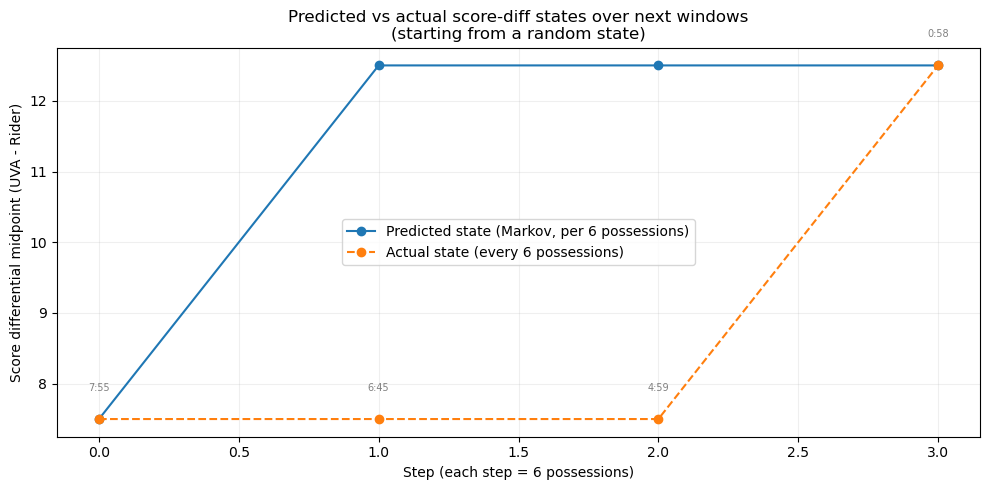

In [35]:
import random
import matplotlib.pyplot as plt

# --- Markov setup ---
states = list(tp_wide.index)
P = tp_wide.loc[states, states].values  # ensure consistent order
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for i, s in enumerate(states)}

window_size = 6      # 1 Markov step = 10 possessions
max_steps = 10        # we WANT 10 steps, but will shrink if game too short
rng = np.random.default_rng(seed=None)

# --- Compute how many full 10-possession windows exist in this game ---
n_plays = len(pbp_with_probs)
total_windows = (n_plays - 1) // window_size   # integer division

if total_windows < 1:
    raise ValueError("Not enough plays to form even one {window_size}-possession window.")

# We can't start so late that we don't have any windows left
# We'll choose a random starting window index (0-based)
# and then limit the number of steps so we don't run past the game.
start_window = random.randint(0, total_windows - 1)

# How many windows can we go from this starting point (including start)?
steps_available = total_windows - start_window
n_steps = min(max_steps, steps_available)  # number of Markov steps we will actually plot

print(f"Total windows available: {total_windows}")
print(f"Random starting window: {start_window}")
print(f"Using n_steps = {n_steps} (each = {window_size} possessions)")

# Convert window index to play index
start_idx = start_window * window_size
start_row = pbp_with_probs.iloc[start_idx]
start_state = start_row["score_diff_state"]

print(f"Start possession index: {start_idx}")
print(f"Time: {start_row['time']}")
print(f"Play: {start_row['play']}")
print(f"Current state: {start_state} (diff={start_row['score_diff']})")

# --- Simulate next n_steps states from Markov chain ({window_size}-possession windows) ---
pred_states = [start_state]  # include current as step 0
cur_idx = state_to_idx[start_state]

for _ in range(n_steps):
    probs = P[cur_idx]
    next_idx = rng.choice(len(probs), p=probs)
    cur_idx = next_idx
    pred_states.append(idx_to_state[cur_idx])

# --- Get actual states at same window boundaries ---
actual_states = []
time_stamps   = []

for k in range(n_steps + 1):  # 0..n_steps inclusive
    row_idx = start_idx + k * window_size
    if row_idx >= n_plays:
        break
    row = pbp_with_probs.iloc[row_idx]
    actual_states.append(row["score_diff_state"])
    time_stamps.append(row["time"])

# Align length (just in case the very end runs short)
m = min(len(pred_states), len(actual_states))
pred_states  = pred_states[:m]
actual_states = actual_states[:m]
steps = list(range(m))

# --- Convert states to numeric midpoints ---
pred_mid   = [state_midpoint(s) for s in pred_states]
actual_mid = [state_midpoint(s) for s in actual_states]

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(steps, pred_mid, marker="o", label=f"Predicted state (Markov, per {window_size} possessions)")
plt.plot(steps, actual_mid, marker="o", linestyle="--", label=f"Actual state (every {window_size} possessions)")

for k in range(m):
    plt.text(steps[k], actual_mid[k] + 0.4, time_stamps[k], fontsize=7, ha="center", color="gray")

plt.xlabel(f"Step (each step = {window_size} possessions)")
plt.ylabel("Score differential midpoint (UVA - Rider)")
plt.title("Predicted vs actual score-diff states over next windows\n(starting from a random state)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()
